In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.optimize import minimize

In [2]:
import models
import experiment as exp
import plots
import utils

In [3]:
from importlib import reload
_ = reload(models)
_ = reload(exp)
_ = reload(plots)
_ = reload(utils)

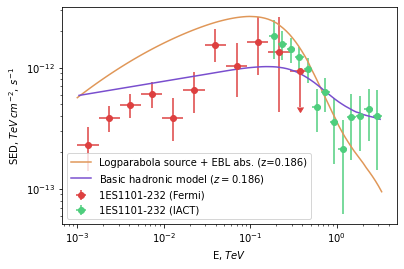

In [4]:
obj = exp.Object.by_name('1ES1101-232')
model = models.LogparabolaThroughEblSED.for_object(obj)
model.set_parameters(*model.estimate_params(obj))

model_basic = models.BasicHadronicModelSED.at_z(obj.z)
model_basic.normalize_to_experimental_sed(obj.seds[0])

fig, ax = plt.subplots(figsize=(6, 4))

obj.plot(ax)
model.plot(ax, E_min=obj.E_min, E_max=obj.E_max)
model_basic.plot(ax, E_min=obj.E_min, E_max=obj.E_max)

ax.legend()
plt.show()

## Single object fit (test)

In [5]:
# ll = obj.get_joint_loglike(model)

# def single_obj_negloglike(theta):
#     return -ll(theta, (1, 1))

# res = minimize(
#     single_obj_negloglike,
#     [1e-12, 0.1, 0.1],
#     method='Nelder-Mead',
#     tol=1e-6,
# )

# model.set_parameters(*res.x)

# fig, ax = plt.subplots(figsize=(6, 4))

# obj.plot(ax)
# model.plot(ax, E_min=obj.E_min, E_max=obj.E_max)

# ax.legend()
# plt.show()

## All objects fit

In [6]:
object_models = []

for obj in exp.all_objects:
    model = models.LogparabolaThroughEblSED.for_object(obj)
    object_models.append(model)

In [7]:
obj_loglikes = [obj.get_joint_loglike(model) for obj, model in zip(exp.all_objects, object_models)]

def all_objects_negloglike(theta):
    logp = 0
    for i, obj_loglike in enumerate(obj_loglikes):
        A, c1, c2 = theta[i * 3 : (i+1) * 3]
        logp += obj_loglike((A, c1, c2), (1, 1))
        if np.isinf(logp):
            break
    return -logp

In [8]:
init_pt = []
for obj, model in zip(exp.all_objects, object_models):
    init_pt.extend(model.estimate_params(obj))

In [9]:
res = minimize(
    all_objects_negloglike,
    init_pt,
    method='Nelder-Mead',
    tol=1e-7,
    options={'maxfev': 5000000},
)

In [10]:
for i, model in enumerate(object_models):
    A, c1, c2 = res.x[i * 3 : (i+1) * 3]
    model.set_parameters(A, c1, c2)

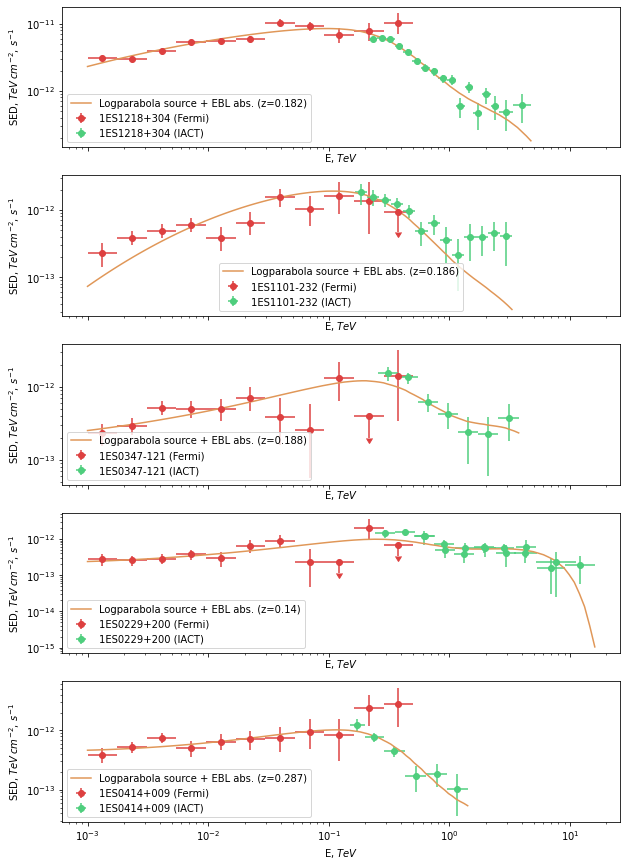

In [13]:
reload(plots)
fig, _ = plots.plot_objects_with_model(exp.all_objects, object_models)

fig.savefig('absorption-only-bestfit.png')

In [12]:
utils.AIC(k=3 * len(exp.all_objects), max_loglikelihood=-all_objects_negloglike(res.x))

185.0914317104416

In [4]:
import numpy as np

p = np.exp((185 - 409) / 2)

In [5]:
p

2.2856936767186716e-49

$P = 2 \times 10^{-49} \quad \rightarrow \quad \approx 14.7 \sigma$

[link](https://www.wolframalpha.com/input/?i=sqrt%282%29+*+erf%5E-1%282+*+2e-49+-+1%29)